In [1]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=0,1

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0,1


/home/yuzhang/tensorflow-py3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10000379068437768756
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11807706317
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13675813756017796396
physical_device_desc: "device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:04:00.0, compute capability: 6.0"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 11807706317
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 11091005138842501577
physical_device_desc: "device: 1, name: Tesla P100-PCIE-12GB, pci bus id: 0000:83:00.0, compute capability: 6.0"
]


In [2]:
import os
import re
import numpy as np
import pandas as pd
import itertools
import nibabel as nib
from pathlib import Path

from tensorpack import dataflow
from tensorpack.utils.utils import get_tqdm
from tensorpack.utils.serialize import dumps, loads
from tensorpack.utils import logger
import lmdb

Instructions for updating:
Use the retry module or similar alternatives.


In [3]:
pathdata = '/home/yuzhang/scratch/HCP/'
pathout = pathdata + "temp_res_new/"

modality = 'WM' #'MOTOR'
###dict for different types of movement
motor_task_con = {"rf": "foot_mot",
                  "lf": "foot_mot",
                  "rh": "hand_mot",
                  "lh": "hand_mot",
                  "t": "tongue_mot"}
wm_task_con   =  {"2bk_body":   "body2b_wm",
                  "2bk_faces":  "face2b_wm",
                  "2bk_places": "place2b_wm",
                  "2bk_tools":  "tool2b_wm",
                  "0bk_body":   "body0b_wm",
                  "0bk_faces":  "face0b_wm",
                  "0bk_places": "place0b_wm",
                  "0bk_tools":  "tool0b_wm"}

task_contrasts = wm_task_con #motor_task_con
target_name = np.unique(pd.Series(list(task_contrasts.values())))
#target_name = np.unique(pd.Series(list(task_contrasts.values())).str.split('_',expand = True)[0])
print(target_name)

mmp_atlas = pathdata + "codes/HCP_S1200_GroupAvg_v1/"+"Q1-Q6_RelatedValidation210.CorticalAreas_dil_Final_Final_Areas_Group_Colors.32k_fs_LR.dlabel.nii"
AtlasName = 'MMP'
block_dura = 1

##############################################
#####start collecting data for classification algorithm
print(modality)
ev_filename = "event_labels_1200R_test_Dec2018_ALL.h5"
events_all_subjects_file = pathout + modality + "_" + ev_filename
print(events_all_subjects_file)
if os.path.isfile(events_all_subjects_file):
    '''
    subjects_trial_labels = pd.read_csv(events_all_subjects_file, sep="\t", encoding="utf8")
    print(subjects_trial_labels.keys())

    subjects_trial_label_matrix = subjects_trial_labels.loc[:, 'trial1':'trial' + str(Trial_Num)]
    sub_name = subjects_trial_labels['subject']
    coding_direct = subjects_trial_labels['coding']
    '''
    subjects_trial_label_matrix = pd.read_hdf(events_all_subjects_file, 'trials')
    subjects_trial_label_matrix = subjects_trial_label_matrix.values.tolist()
    sub_name = pd.read_hdf(events_all_subjects_file, 'subject')
    coding_direct = pd.read_hdf(events_all_subjects_file, 'coding')

    print("Data samples including %d event files consisting of %d subjects, each has %d coding directions and %d trials \n\n"
          % (len(sub_name), len(np.unique(sub_name)), np.ceil(len(coding_direct)/len(np.unique(sub_name))), np.array(subjects_trial_label_matrix).shape[1]))

print(np.array(subjects_trial_label_matrix).shape)
print(len(sub_name),len(coding_direct))

['body0b_wm' 'body2b_wm' 'face0b_wm' 'face2b_wm' 'place0b_wm' 'place2b_wm'
 'tool0b_wm' 'tool2b_wm']
WM
/home/yuzhang/scratch/HCP/temp_res_new/WM_event_labels_1200R_test_Dec2018_ALL.h5
Data samples including 2149 event files consisting of 1 subjects, each has 2149 coding directions and 405 trials 


(2149, 405)
2149 2149


In [19]:
TR=0.72
ev = pathdata +"aws_s3_HCP1200/FMRI/tfMRI_WM_LR/100206_combined_events_spm_WM.csv"
trial_infos = pd.read_csv(ev,sep="\t",encoding="utf8",header = None,names=['onset','duration','rep','task'])
Duras = np.ceil((trial_infos.duration/TR)).astype(int) #(trial_infos.duration/TR).astype(int)
print(Duras)

0    39
1    39
2    39
3    39
4    39
5    39
6    39
7    39
Name: duration, dtype: int64


In [4]:
from tensorpack.utils.serialize import dumps, loads
import lmdb
lmdb_filename = pathout+modality+"_MMP_ROI_act_1200R_test_Dec2018_ALL.lmdb"

## read lmdb matrix
print('loading data from file: %s' % lmdb_filename)
matrix_dict = []
fmri_sub_name = []
lmdb_env = lmdb.open(lmdb_filename, subdir=False)
try:
    lmdb_txn = lmdb_env.begin()
    listed_fmri_files = loads(lmdb_txn.get(b'__keys__'))
    listed_fmri_files = [l.decode("utf-8") for l in listed_fmri_files]
    print('Stored fmri data from files:')
    print(len(listed_fmri_files))
except:
    print('Search each key for every fmri file...')

with lmdb_env.begin() as lmdb_txn:
    cursor = lmdb_txn.cursor()
    for key, value in cursor:
        #print(key)
        if key == b'__keys__':
            continue
        pathsub = Path(os.path.dirname(key.decode("utf-8")))
        if any('REST' in string for string in lmdb_filename.split('_')):
            fmri_sub_name.append(pathsub.parts[-3] + '_' + pathsub.parts[-1].split('_')[-2][-1] + '_' + pathsub.parts[-1].split('_')[-1])
        else:
            fmri_sub_name.append(pathsub.parts[-3] + '_' + pathsub.parts[-1].split('_')[-1])
        data = loads(lmdb_txn.get(key))
        if any('REST' in string for string in lmdb_filename.split('_')):
            if data is None or data.shape[0] != Trial_Num:
                print('fmri data shape mis-matching between subjects...')
                print('Check subject:  %s with only %d Trials \n' % (fmri_sub_name[-1], data.shape[0]))
                del fmri_sub_name[-1]
            else:
                matrix_dict.append(np.array(data))
        else:
            matrix_dict.append(np.array(data))
lmdb_env.close()

subjects_tc_matrix = matrix_dict
subname_coding = fmri_sub_name
print(np.array(subjects_tc_matrix).shape)
print(subjects_tc_matrix[0].shape)



loading data from file: /home/yuzhang/scratch/HCP/temp_res_new/WM_MMP_ROI_act_1200R_test_Dec2018_ALL.lmdb
Search each key for every fmri file...
(2149,)
(405, 360)


In [5]:
def preclean_data_for_shape_match(subjects_tc_matrix,subjects_trial_label_matrix, fmri_sub_name):
    print("Pre-clean the fmri and event data to make sure the matching shapes between two arrays!")
    Subject_Num = np.array(subjects_tc_matrix).shape[0]
    Trial_Num, Region_Num = subjects_tc_matrix[0].shape
    if np.array(subjects_trial_label_matrix).shape[0] != Subject_Num:
        print('Warning: Mis-matching subjects list between fmri-data-matrix and trial-label-matrix')
        print(np.array(subjects_tc_matrix).shape,np.array(subjects_trial_label_matrix).shape)

    for subj in range(Subject_Num):
        try:
            tsize, rsize = subjects_tc_matrix[subj].shape
        except:
            print(subj==Subject_Num-1)
            print('The end of SubjectList...\n')
        if tsize != Trial_Num:
            print('Remove subject: %s due to different trial num: %d in the fmri data' % (fmri_sub_name[subj],tsize))
            del subjects_tc_matrix[subj]
            del subjects_trial_label_matrix[subj]
        if rsize != Region_Num:
            print('Remove subject: %s due to different region num: %d in the fmri data' % (fmri_sub_name[subj],rsize))
            del subjects_tc_matrix[subj]
            del subjects_trial_label_matrix[subj]

    print('Done matching data shapes:',np.array(subjects_tc_matrix).shape,np.array(subjects_trial_label_matrix).shape)
    return subjects_tc_matrix, subjects_trial_label_matrix

subjects_tc_matrix_new, subjects_trial_label_matrix_new = preclean_data_for_shape_match(subjects_tc_matrix,subjects_trial_label_matrix,subname_coding)
Subject_Num = np.array(subjects_tc_matrix_new).shape[0]
print(np.array(subjects_trial_label_matrix_new).shape)
print(np.array(subjects_tc_matrix_new).shape)
print(np.unique(subjects_trial_label_matrix_new))

Pre-clean the fmri and event data to make sure the matching shapes between two arrays!
Remove subject: aws_s3_HCP1200_LR due to different trial num: 320 in the fmri data
True
The end of SubjectList...

Done matching data shapes: (2148, 405, 360) (2148, 405)
(2148, 405)
(2148, 405, 360)
['body0b_wm' 'body2b_wm' 'face0b_wm' 'face2b_wm' 'place0b_wm' 'place2b_wm'
 'rest' 'tool0b_wm' 'tool2b_wm']


In [12]:
def subject_cross_validation_split_trials(tc_matrix, label_matrix,target_name, sub_num=None, block_dura=18, n_folds=10, testsize=0.2, valsize=0.1,randomseed=1234):
    ##randomseed=1234;testsize = 0.2;n_folds=10;valsize=0.1
    from sklearn import preprocessing
    from sklearn.model_selection import cross_val_score, train_test_split,ShuffleSplit
    
    Subject_Num, Trial_Num, Region_Num = np.array(tc_matrix).shape
    rs = np.random.RandomState(randomseed)
    if not sub_num or sub_num>Subject_Num:
        sub_num = Subject_Num
    if not block_dura:
        block_dura = 18 ###12s block for MOTOR task

    fmri_data_matrix = []
    label_data_matrix = []
    for subi in range(Subject_Num):
        label_trial_data = np.array(label_matrix[subi])
        condition_mask = pd.Series(label_trial_data).isin(target_name)
        ##condition_mask = pd.Series(label_trial_data).str.split('_', expand=True)[0].isin(target_name)
        fmri_data_matrix.append(tc_matrix[subi][condition_mask, :])
        label_data_matrix.append(label_trial_data[condition_mask])
    fmri_data_matrix = np.array(fmri_data_matrix).astype('float32', casting='same_kind')
    label_data_matrix = np.array(label_data_matrix)
    ##cut the trials into blocks
    chunks = int(np.floor(label_data_matrix.shape[-1] / block_dura))
    fmri_data_block = np.array(np.array_split(fmri_data_matrix, chunks, axis=1)).mean(axis=2).astype('float32',casting='same_kind')
    label_data_block = np.array(np.array_split(label_data_matrix, chunks, axis=1))[:, :, 0]
    # print(fmri_data_block.shape,label_data_block.shape)

    train_sid_tmp, test_sid = train_test_split(range(sub_num), test_size=testsize, random_state=rs, shuffle=True)
    fmri_data_train = np.array([fmri_data_block[:, i, :] for i in train_sid_tmp]).astype('float32', casting='same_kind')
    fmri_data_test = np.array([fmri_data_block[:, i, :] for i in test_sid]).astype('float32', casting='same_kind')
    # print(fmri_data_train.shape,fmri_data_test.shape)

    label_data_train = np.array([label_data_block[:, i] for i in train_sid_tmp])
    label_data_test = np.array([label_data_block[:, i] for i in test_sid])
    # print(label_data_train.shape,label_data_test.shape)

    ###transform the data
    scaler = preprocessing.StandardScaler().fit(np.vstack(fmri_data_train))
    ##fmri_data_train = scaler.transform(fmri_data_train)
    X_test = scaler.transform(np.vstack(fmri_data_test))
    nb_class = len(np.unique(label_data_block))
    Y_test = label_data_test.ravel()
    # print(X_test.shape,Y_test.shape)

    from sklearn.model_selection import ShuffleSplit
    valsplit = ShuffleSplit(n_splits=n_folds, test_size=valsize, random_state=rs)
    X_train_scaled = []
    X_val_scaled = []
    Y_train_scaled = []
    Y_val_scaled = []
    for train_sid, val_sid in valsplit.split(train_sid_tmp):
        ##preprocess features and labels
        X = np.array(np.vstack([fmri_data_train[i, :, :] for i in train_sid]))
        Y = np.array([label_data_train[i, :] for i in train_sid]).ravel()
        # print(X.shape, Y.shape)
        X_train_scaled.append(scaler.transform(X))
        Y_train_scaled.append(Y)

        X = np.array(np.vstack([fmri_data_train[i, :, :] for i in val_sid]))
        Y = np.array([label_data_train[i, :] for i in val_sid]).ravel()
        # print(X.shape, Y.shape)
        X_val_scaled.append(scaler.transform(X))
        Y_val_scaled.append(Y)

    print('Samples of Subjects for training: %d and testing %d and validating %d with %d classes' % (
    len(train_sid), len(test_sid), len(val_sid), nb_class))
    return X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled, X_test, Y_test

    
##########################################
Subject_Num, Trial_Num, Region_Num = np.array(subjects_tc_matrix_new).shape
if Trial_Num != np.array(subjects_trial_label_matrix_new).shape[1]:
    print('Miss-matching trial infos for event and fmri data')
if Subject_Num != np.array(subjects_trial_label_matrix_new).shape[0]:
    print('Adjust subject numbers for event data')
    subjects_trial_label_matrix = np.array(subjects_trial_label_matrix_new[:Subject_Num])
else:
    subjects_trial_label_matrix = np.array(subjects_trial_label_matrix_new)

    
block_dura = 39
##split data into train, val and test in subject-level
X_train, Y_train, X_val, Y_val, X_test, Y_test = \
subject_cross_validation_split_trials(subjects_tc_matrix_new, subjects_trial_label_matrix,target_name,block_dura=block_dura)

from sklearn import preprocessing
X_train_all = np.array(np.vstack((X_train[0], X_val[0])))
Y_train_all = np.array(np.concatenate((Y_train[0], Y_val[0]), axis=0))
print('sample size for training and testing: ', X_train_all.shape, Y_train_all.shape)
le = preprocessing.LabelEncoder()
le.fit(np.unique(Y_train_all))
Y_train_int = le.transform(Y_train_all)
Y_test_int = le.transform(Y_test)



Samples of Subjects for training: 1546 and testing 430 and validating 172 with 8 classes
sample size for training and testing:  (13744, 360) (13744,)


/home/yuzhang/scratch/HCP/codes/MMP_adjacency_mat_white.pconn.nii


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


(360, 360)


Text(0.5,1.05,'Adjacency Matrix on white surface')

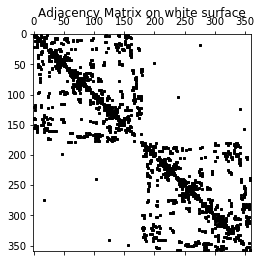

In [7]:
###build the graph
#first cal gdistance in surface using wb_command
#!wb_command -cifti-label-adjacency Q1-Q6_RelatedValidation210.CorticalAreas_dil_Final_Final_Areas_Group_Colors.32k_fs_LR.dlabel.nii MMP_adjacency_mat.pconn.nii -left-surface S1200.L.white_MSMAll.32k_fs_LR.surf.gii -right-surface S1200.R.white_MSMAll.32k_fs_LR.surf.gii
import imp 
from lib import models, graph, coarsening, utils
imp.reload(utils)
imp.reload(models)
imp.reload(graph)
imp.reload(coarsening)
from scipy import sparse

import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline

adj_mat_file = pathdata + 'codes/MMP_adjacency_mat_white.pconn.nii'
print(adj_mat_file)
adj_mat = nib.load(adj_mat_file).get_data()
print(adj_mat.shape)

#plt.spy(adj_mat, markersize=2, color='black');

adj_mat = sparse.csr_matrix(adj_mat)
A = graph.replace_random_edges(adj_mat, 0.01)
plt.spy(A, markersize=2, color='black');
plt.title("Adjacency Matrix on white surface")

###build the graph
###using rsfc
adj_mat_file = pathdata + 'temp_res/REST_MMP_rsfc_matrix_1200R_ALL.h5'
print(adj_mat_file)
adj_mat = nib.load(adj_mat_file).get_data()
print(adj_mat.shape)


In [8]:
import time
import tensorflow as tf
flags = tf.app.flags
FLAGS = flags.FLAGS

# Graphs.
flags.DEFINE_integer('number_edges', 8, 'Graph: minimum number of edges per vertex.')
flags.DEFINE_string('metric', 'euclidean', 'Graph: similarity measure (between features).')
# TODO: change cgcnn for combinatorial Laplacians.
flags.DEFINE_bool('normalized_laplacian', True, 'Graph Laplacian: normalized.')
flags.DEFINE_integer('coarsening_levels', 6, 'Number of coarsened graphs.')

# Directories.
flags.DEFINE_string('dir_data', os.path.join(pathout, 'data', modality), 'Directory to store data.')

Layer 0: M_0 = |V| = 576 nodes (216 added),|E| = 1053 edges
Layer 1: M_1 = |V| = 288 nodes (95 added),|E| = 561 edges
Layer 2: M_2 = |V| = 144 nodes (40 added),|E| = 299 edges
Layer 3: M_3 = |V| = 72 nodes (17 added),|E| = 152 edges
Layer 4: M_4 = |V| = 36 nodes (7 added),|E| = 79 edges
Layer 5: M_5 = |V| = 18 nodes (2 added),|E| = 41 edges
Layer 6: M_6 = |V| = 9 nodes (0 added),|E| = 21 edges


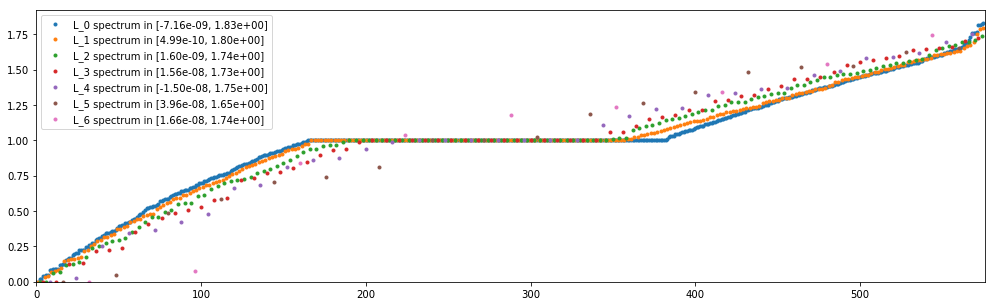

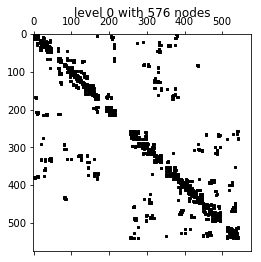

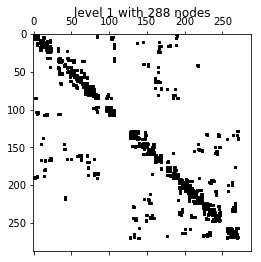

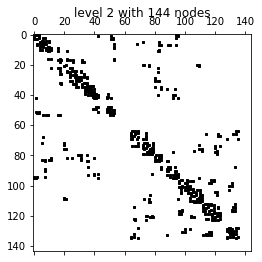

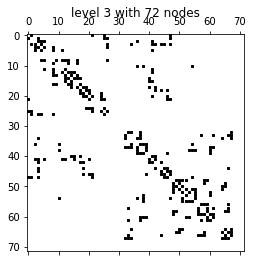

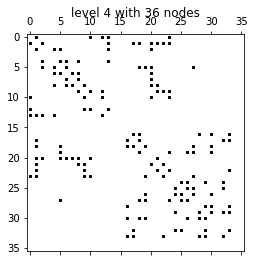

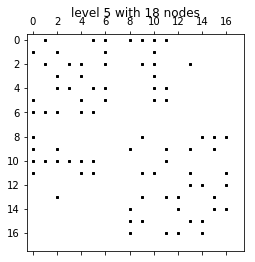

In [9]:
###build multi-level graph using coarsen (div by 2 at each level)
coarsening_levels = 6
graphs, perm = coarsening.coarsen(A, levels=coarsening_levels, self_connections=False)
L = [graph.laplacian(A, normalized=True) for A in graphs]
graph.plot_spectrum(L)

for li in range(coarsening_levels):
    plt.figure()
    plt.spy(graphs[li], markersize=2, color='black');
    plt.title('level %d with %d nodes' % (li,graphs[li].shape[0]))

In [10]:
import time
import tensorflow as tf

common = {}
common['dir_name']       = modality
common['num_epochs']     = 50 ###20
common['batch_size']     = 128
common['decay_steps']    = X_train[0].shape[0] / common['batch_size']
common['eval_frequency'] = 30 * common['num_epochs']
common['brelu']          = 'b1relu'
common['pool']           = 'mpool1'
C = len(np.unique(Y_test)) + 1  # number of classes


model_perf = utils.model_perf()

['body0b_wm' 'body2b_wm' 'face0b_wm' 'face2b_wm' 'place0b_wm' 'place2b_wm'
 'tool0b_wm' 'tool2b_wm']

Fold #1: training on 482352 samples with 576 features, validating on 53664 samples and testing on 134160 samples
NN architecture
  input: M_0 = 576
  layer 1: logits (softmax)
    representation: M_1 = 9
    weights: M_0 * M_1 = 576 * 9 = 5184
    biases: M_1 = 9
step 1500 / 188418 (epoch 0.40 / 50):
  learning_rate = 2.00e-02, loss_average = 1.44e+00
  validation accuracy: 51.89 (27845 / 53664), f1 (weighted): 51.86, loss: 1.44e+00
  time: 5s (wall 3s)
step 3000 / 188418 (epoch 0.80 / 50):
  learning_rate = 2.00e-02, loss_average = 1.40e+00
  validation accuracy: 52.31 (28074 / 53664), f1 (weighted): 52.26, loss: 1.44e+00
  time: 9s (wall 6s)
step 4500 / 188418 (epoch 1.19 / 50):
  learning_rate = 1.90e-02, loss_average = 1.39e+00
  validation accuracy: 52.67 (28264 / 53664), f1 (weighted): 52.58, loss: 1.44e+00
  time: 14s (wall 8s)
step 6000 / 188418 (epoch 1.59 / 50):
  learning_ra

step 61500 / 188418 (epoch 16.32 / 50):
  learning_rate = 8.80e-03, loss_average = 1.35e+00
  validation accuracy: 54.32 (29152 / 53664), f1 (weighted): 54.30, loss: 1.38e+00
  time: 182s (wall 102s)
step 63000 / 188418 (epoch 16.72 / 50):
  learning_rate = 8.80e-03, loss_average = 1.33e+00
  validation accuracy: 53.37 (28642 / 53664), f1 (weighted): 53.37, loss: 1.40e+00
  time: 186s (wall 104s)
step 64500 / 188418 (epoch 17.12 / 50):
  learning_rate = 8.36e-03, loss_average = 1.30e+00
  validation accuracy: 53.98 (28967 / 53664), f1 (weighted): 53.91, loss: 1.38e+00
  time: 190s (wall 107s)
step 66000 / 188418 (epoch 17.51 / 50):
  learning_rate = 8.36e-03, loss_average = 1.39e+00
  validation accuracy: 54.09 (29025 / 53664), f1 (weighted): 54.02, loss: 1.38e+00
  time: 195s (wall 109s)
step 67500 / 188418 (epoch 17.91 / 50):
  learning_rate = 8.36e-03, loss_average = 1.31e+00
  validation accuracy: 54.66 (29334 / 53664), f1 (weighted): 54.67, loss: 1.37e+00
  time: 199s (wall 112s)


step 123000 / 188418 (epoch 32.64 / 50):
  learning_rate = 3.87e-03, loss_average = 1.30e+00
  validation accuracy: 55.16 (29600 / 53664), f1 (weighted): 55.16, loss: 1.36e+00
  time: 361s (wall 202s)
step 124500 / 188418 (epoch 33.04 / 50):
  learning_rate = 3.68e-03, loss_average = 1.29e+00
  validation accuracy: 54.99 (29508 / 53664), f1 (weighted): 54.97, loss: 1.36e+00
  time: 366s (wall 205s)
step 126000 / 188418 (epoch 33.44 / 50):
  learning_rate = 3.68e-03, loss_average = 1.29e+00
  validation accuracy: 55.20 (29625 / 53664), f1 (weighted): 55.19, loss: 1.35e+00
  time: 370s (wall 207s)
step 127500 / 188418 (epoch 33.83 / 50):
  learning_rate = 3.68e-03, loss_average = 1.33e+00
  validation accuracy: 55.25 (29647 / 53664), f1 (weighted): 55.22, loss: 1.35e+00
  time: 375s (wall 210s)
step 129000 / 188418 (epoch 34.23 / 50):
  learning_rate = 3.50e-03, loss_average = 1.31e+00
  validation accuracy: 55.00 (29516 / 53664), f1 (weighted): 54.97, loss: 1.36e+00
  time: 379s (wall 2

step 184500 / 188418 (epoch 48.96 / 50):
  learning_rate = 1.71e-03, loss_average = 1.27e+00
  validation accuracy: 55.54 (29807 / 53664), f1 (weighted): 55.51, loss: 1.35e+00
  time: 542s (wall 303s)
step 186000 / 188418 (epoch 49.36 / 50):
  learning_rate = 1.62e-03, loss_average = 1.33e+00
  validation accuracy: 55.45 (29756 / 53664), f1 (weighted): 55.43, loss: 1.35e+00
  time: 547s (wall 306s)
step 187500 / 188418 (epoch 49.76 / 50):
  learning_rate = 1.62e-03, loss_average = 1.32e+00
  validation accuracy: 55.61 (29841 / 53664), f1 (weighted): 55.57, loss: 1.35e+00
  time: 551s (wall 308s)
step 188418 / 188418 (epoch 50.00 / 50):
  learning_rate = 1.62e-03, loss_average = 1.31e+00
  validation accuracy: 55.68 (29882 / 53664), f1 (weighted): 55.67, loss: 1.35e+00
  time: 554s (wall 310s)
validation accuracy: peak = 55.68, mean = 55.50
step 1500 / 188418 (epoch 0.40 / 50):
  learning_rate = 2.00e-02, loss_average = 1.39e+00
  validation accuracy: 52.68 (28268 / 53664), f1 (weighted

  validation accuracy: 53.83 (28886 / 53664), f1 (weighted): 53.79, loss: 1.39e+00
  time: 169s (wall 95s)
step 58500 / 188418 (epoch 15.52 / 50):
  learning_rate = 9.27e-03, loss_average = 1.32e+00
  validation accuracy: 54.24 (29105 / 53664), f1 (weighted): 54.20, loss: 1.38e+00
  time: 173s (wall 97s)
step 60000 / 188418 (epoch 15.92 / 50):
  learning_rate = 9.27e-03, loss_average = 1.34e+00
  validation accuracy: 53.63 (28778 / 53664), f1 (weighted): 53.61, loss: 1.38e+00
  time: 178s (wall 100s)
step 61500 / 188418 (epoch 16.32 / 50):
  learning_rate = 8.80e-03, loss_average = 1.33e+00
  validation accuracy: 54.21 (29090 / 53664), f1 (weighted): 54.21, loss: 1.38e+00
  time: 182s (wall 102s)
step 63000 / 188418 (epoch 16.72 / 50):
  learning_rate = 8.80e-03, loss_average = 1.33e+00
  validation accuracy: 53.34 (28626 / 53664), f1 (weighted): 53.34, loss: 1.40e+00
  time: 187s (wall 104s)
step 64500 / 188418 (epoch 17.12 / 50):
  learning_rate = 8.36e-03, loss_average = 1.33e+00
  

  validation accuracy: 54.49 (29242 / 53664), f1 (weighted): 54.45, loss: 1.37e+00
  time: 350s (wall 196s)
step 120000 / 188418 (epoch 31.84 / 50):
  learning_rate = 4.08e-03, loss_average = 1.33e+00
  validation accuracy: 55.11 (29575 / 53664), f1 (weighted): 55.09, loss: 1.36e+00
  time: 354s (wall 198s)
step 121500 / 188418 (epoch 32.24 / 50):
  learning_rate = 3.87e-03, loss_average = 1.33e+00
  validation accuracy: 55.01 (29518 / 53664), f1 (weighted): 54.98, loss: 1.35e+00
  time: 359s (wall 201s)
step 123000 / 188418 (epoch 32.64 / 50):
  learning_rate = 3.87e-03, loss_average = 1.30e+00
  validation accuracy: 54.60 (29300 / 53664), f1 (weighted): 54.57, loss: 1.36e+00
  time: 363s (wall 203s)
step 124500 / 188418 (epoch 33.04 / 50):
  learning_rate = 3.68e-03, loss_average = 1.28e+00
  validation accuracy: 55.14 (29589 / 53664), f1 (weighted): 55.11, loss: 1.35e+00
  time: 368s (wall 206s)
step 126000 / 188418 (epoch 33.44 / 50):
  learning_rate = 3.68e-03, loss_average = 1.33

  validation accuracy: 55.43 (29746 / 53664), f1 (weighted): 55.40, loss: 1.35e+00
  time: 530s (wall 297s)
step 181500 / 188418 (epoch 48.16 / 50):
  learning_rate = 1.71e-03, loss_average = 1.28e+00
  validation accuracy: 55.36 (29710 / 53664), f1 (weighted): 55.33, loss: 1.35e+00
  time: 534s (wall 299s)
step 183000 / 188418 (epoch 48.56 / 50):
  learning_rate = 1.71e-03, loss_average = 1.29e+00
  validation accuracy: 55.51 (29791 / 53664), f1 (weighted): 55.50, loss: 1.35e+00
  time: 539s (wall 302s)
step 184500 / 188418 (epoch 48.96 / 50):
  learning_rate = 1.71e-03, loss_average = 1.29e+00
  validation accuracy: 55.44 (29751 / 53664), f1 (weighted): 55.42, loss: 1.35e+00
  time: 543s (wall 304s)
step 186000 / 188418 (epoch 49.36 / 50):
  learning_rate = 1.62e-03, loss_average = 1.30e+00
  validation accuracy: 55.50 (29781 / 53664), f1 (weighted): 55.47, loss: 1.35e+00
  time: 547s (wall 306s)
step 187500 / 188418 (epoch 49.76 / 50):
  learning_rate = 1.62e-03, loss_average = 1.28

step 48000 / 188418 (epoch 12.74 / 50):
  learning_rate = 1.08e-02, loss_average = 1.36e+00
  validation accuracy: 55.42 (29738 / 53664), f1 (weighted): 55.40, loss: 1.36e+00
  time: 140s (wall 79s)
step 49500 / 188418 (epoch 13.14 / 50):
  learning_rate = 1.03e-02, loss_average = 1.38e+00
  validation accuracy: 55.17 (29608 / 53664), f1 (weighted): 55.18, loss: 1.35e+00
  time: 144s (wall 81s)
step 51000 / 188418 (epoch 13.53 / 50):
  learning_rate = 1.03e-02, loss_average = 1.36e+00
  validation accuracy: 55.20 (29625 / 53664), f1 (weighted): 55.18, loss: 1.36e+00
  time: 149s (wall 83s)
step 52500 / 188418 (epoch 13.93 / 50):
  learning_rate = 1.03e-02, loss_average = 1.31e+00
  validation accuracy: 55.04 (29536 / 53664), f1 (weighted): 55.01, loss: 1.35e+00
  time: 153s (wall 86s)
step 54000 / 188418 (epoch 14.33 / 50):
  learning_rate = 9.75e-03, loss_average = 1.32e+00
  validation accuracy: 54.82 (29418 / 53664), f1 (weighted): 54.78, loss: 1.37e+00
  time: 157s (wall 88s)
step 

step 109500 / 188418 (epoch 29.06 / 50):
  learning_rate = 4.52e-03, loss_average = 1.33e+00
  validation accuracy: 56.05 (30077 / 53664), f1 (weighted): 56.04, loss: 1.33e+00
  time: 317s (wall 178s)
step 111000 / 188418 (epoch 29.46 / 50):
  learning_rate = 4.52e-03, loss_average = 1.31e+00
  validation accuracy: 56.22 (30168 / 53664), f1 (weighted): 56.20, loss: 1.33e+00
  time: 322s (wall 180s)
step 112500 / 188418 (epoch 29.85 / 50):
  learning_rate = 4.52e-03, loss_average = 1.33e+00
  validation accuracy: 55.82 (29956 / 53664), f1 (weighted): 55.80, loss: 1.33e+00
  time: 326s (wall 183s)
step 114000 / 188418 (epoch 30.25 / 50):
  learning_rate = 4.29e-03, loss_average = 1.31e+00
  validation accuracy: 56.23 (30174 / 53664), f1 (weighted): 56.21, loss: 1.33e+00
  time: 330s (wall 185s)
step 115500 / 188418 (epoch 30.65 / 50):
  learning_rate = 4.29e-03, loss_average = 1.29e+00
  validation accuracy: 56.29 (30210 / 53664), f1 (weighted): 56.26, loss: 1.33e+00
  time: 335s (wall 1

step 171000 / 188418 (epoch 45.38 / 50):
  learning_rate = 1.99e-03, loss_average = 1.30e+00
  validation accuracy: 56.61 (30377 / 53664), f1 (weighted): 56.59, loss: 1.32e+00
  time: 495s (wall 278s)
step 172500 / 188418 (epoch 45.78 / 50):
  learning_rate = 1.99e-03, loss_average = 1.29e+00
  validation accuracy: 56.57 (30359 / 53664), f1 (weighted): 56.56, loss: 1.32e+00
  time: 500s (wall 280s)
step 174000 / 188418 (epoch 46.17 / 50):
  learning_rate = 1.89e-03, loss_average = 1.28e+00
  validation accuracy: 56.34 (30232 / 53664), f1 (weighted): 56.32, loss: 1.32e+00
  time: 504s (wall 283s)
step 175500 / 188418 (epoch 46.57 / 50):
  learning_rate = 1.89e-03, loss_average = 1.29e+00
  validation accuracy: 56.59 (30366 / 53664), f1 (weighted): 56.58, loss: 1.32e+00
  time: 508s (wall 285s)
step 177000 / 188418 (epoch 46.97 / 50):
  learning_rate = 1.89e-03, loss_average = 1.26e+00
  validation accuracy: 56.73 (30445 / 53664), f1 (weighted): 56.72, loss: 1.32e+00
  time: 513s (wall 2

  validation accuracy: 54.90 (29462 / 53664), f1 (weighted): 54.92, loss: 1.36e+00
  time: 128s (wall 72s)
step 45000 / 188418 (epoch 11.94 / 50):
  learning_rate = 1.14e-02, loss_average = 1.34e+00
  validation accuracy: 54.29 (29136 / 53664), f1 (weighted): 54.27, loss: 1.37e+00
  time: 132s (wall 74s)
step 46500 / 188418 (epoch 12.34 / 50):
  learning_rate = 1.08e-02, loss_average = 1.35e+00
  validation accuracy: 54.83 (29425 / 53664), f1 (weighted): 54.80, loss: 1.36e+00
  time: 136s (wall 76s)
step 48000 / 188418 (epoch 12.74 / 50):
  learning_rate = 1.08e-02, loss_average = 1.35e+00
  validation accuracy: 55.25 (29648 / 53664), f1 (weighted): 55.25, loss: 1.35e+00
  time: 140s (wall 79s)
step 49500 / 188418 (epoch 13.14 / 50):
  learning_rate = 1.03e-02, loss_average = 1.31e+00
  validation accuracy: 55.32 (29686 / 53664), f1 (weighted): 55.30, loss: 1.35e+00
  time: 145s (wall 81s)
step 51000 / 188418 (epoch 13.53 / 50):
  learning_rate = 1.03e-02, loss_average = 1.37e+00
  val

step 106500 / 188418 (epoch 28.26 / 50):
  learning_rate = 4.76e-03, loss_average = 1.35e+00
  validation accuracy: 55.91 (30003 / 53664), f1 (weighted): 55.88, loss: 1.33e+00
  time: 310s (wall 173s)
step 108000 / 188418 (epoch 28.66 / 50):
  learning_rate = 4.76e-03, loss_average = 1.29e+00
  validation accuracy: 56.28 (30202 / 53664), f1 (weighted): 56.26, loss: 1.33e+00
  time: 314s (wall 176s)
step 109500 / 188418 (epoch 29.06 / 50):
  learning_rate = 4.52e-03, loss_average = 1.33e+00
  validation accuracy: 56.09 (30098 / 53664), f1 (weighted): 56.08, loss: 1.33e+00
  time: 319s (wall 178s)
step 111000 / 188418 (epoch 29.46 / 50):
  learning_rate = 4.52e-03, loss_average = 1.34e+00
  validation accuracy: 56.09 (30098 / 53664), f1 (weighted): 56.05, loss: 1.33e+00
  time: 323s (wall 181s)
step 112500 / 188418 (epoch 29.85 / 50):
  learning_rate = 4.52e-03, loss_average = 1.34e+00
  validation accuracy: 56.25 (30185 / 53664), f1 (weighted): 56.28, loss: 1.33e+00
  time: 327s (wall 1

step 168000 / 188418 (epoch 44.58 / 50):
  learning_rate = 2.09e-03, loss_average = 1.28e+00
  validation accuracy: 56.52 (30333 / 53664), f1 (weighted): 56.51, loss: 1.32e+00
  time: 489s (wall 273s)
step 169500 / 188418 (epoch 44.98 / 50):
  learning_rate = 2.09e-03, loss_average = 1.31e+00
  validation accuracy: 56.59 (30368 / 53664), f1 (weighted): 56.58, loss: 1.32e+00
  time: 493s (wall 275s)
step 171000 / 188418 (epoch 45.38 / 50):
  learning_rate = 1.99e-03, loss_average = 1.27e+00
  validation accuracy: 56.56 (30353 / 53664), f1 (weighted): 56.55, loss: 1.32e+00
  time: 498s (wall 278s)
step 172500 / 188418 (epoch 45.78 / 50):
  learning_rate = 1.99e-03, loss_average = 1.34e+00
  validation accuracy: 56.46 (30297 / 53664), f1 (weighted): 56.46, loss: 1.32e+00
  time: 503s (wall 281s)
step 174000 / 188418 (epoch 46.17 / 50):
  learning_rate = 1.89e-03, loss_average = 1.29e+00
  validation accuracy: 56.54 (30340 / 53664), f1 (weighted): 56.53, loss: 1.32e+00
  time: 507s (wall 2

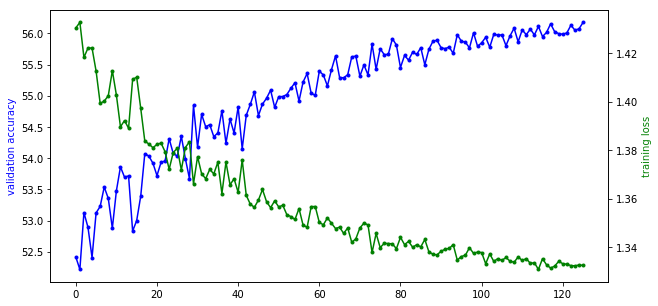

In [11]:
###test different param settins
##model1: no convolution
name = 'softmax'
params = common.copy()
params['dir_name'] += name
params['regularization'] = 5e-4
params['dropout']        = 1
params['learning_rate']  = 0.02
params['decay_rate']     = 0.95
params['momentum']       = 0.9
params['F']              = []
params['K']              = []
params['p']              = []
params['M']              = [C]

d = {k: v+1 for v, k in enumerate(sorted(set(Y_test)))}
test_labels = np.array([d[x] for x in Y_test])
print(np.unique(Y_test))

train_acc = []; train_loss = [];
test_acc = []; test_loss = [];
val_acc = []; val_loss = [];
accuracy = []; loss = []; t_step = [];
for x_train, y_train, x_val, y_val,tcount in zip(X_train, Y_train, X_val, Y_val,range(2)):
    
    train_data = coarsening.perm_data(x_train.reshape(-1,Region_Num), perm)
    train_labels = np.array([d[x] for x in y_train])
    val_data = coarsening.perm_data(x_val.reshape(-1,Region_Num), perm)
    val_labels = np.array([d[x] for x in y_val])
    test_data = coarsening.perm_data(X_test.reshape(-1,Region_Num), perm)
    print('\nFold #%d: training on %d samples with %d features, validating on %d samples and testing on %d samples' % 
          (tcount+1,train_data.shape[0],train_data.shape[1],val_data.shape[0],test_data.shape[0]))  
    
    ###training
    model = models.cgcnn(L, **params)
    acc, los, tstep = model.fit(train_data, train_labels, val_data, val_labels)
    accuracy.append(acc)
    loss.append(los)
    t_step.append(tstep)

    ##evaluation
    model_perf.test(model, name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)
    train_acc.append(model_perf.train_accuracy[name])
    train_loss.append(model_perf.train_loss[name])
    test_acc.append(model_perf.test_accuracy[name])
    test_loss.append(model_perf.test_loss[name])
    val_acc.append(model_perf.fit_accuracies[name])
    val_loss.append(model_perf.fit_losses[name])
    print('\n')
       
print('Accuracy of training:{},testing:{}'.format(np.mean(train_acc),np.mean(test_acc)))
print('Accuracy of validation:',np.max(val_acc,axis=1))
print(' mean=%2f' % np.mean(np.max(val_acc,axis=1)))


###training figures
print(accuracy, loss,t_step )
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(np.mean(accuracy,axis=0), 'b.-')
ax1.set_ylabel('validation accuracy', color='b')
ax2 = ax1.twinx()
ax2.plot(np.mean(loss,axis=0), 'g.-')
ax2.set_ylabel('training loss', color='g')
plt.show()


[576 144  36]
[(576, 576), (288, 288), (144, 144), (72, 72), (36, 36), (18, 18), (9, 9)]
NN architecture
  input: M_0 = 576
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 576 * 32 / 4 = 4608
    weights: F_0 * F_1 * K_1 = 1 * 32 * 576 = 18432
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 144 * 64 / 4 = 2304
    weights: F_1 * F_2 * K_2 = 32 * 64 * 144 = 294912
    biases: F_2 = 64
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 36 * 128 / 4 = 1152
    weights: F_2 * F_3 * K_3 = 64 * 128 * 36 = 294912
    biases: F_3 = 128
  layer 4: fc1
    representation: M_4 = 256
    weights: M_3 * M_4 = 1152 * 256 = 294912
    biases: M_4 = 256
  layer 5: logits (softmax)
    representation: M_5 = 9
    weights: M_4 * M_5 = 256 * 9 = 2304
    biases: M_5 = 9
['body0b_wm' 'body2b_wm' 'face0b_wm' 'face2b_wm' 'place0b_wm' 'place2b_wm'
 'tool0b_wm' 'tool2b_wm']

Fold #1: training on 12368 samples with 576 features, validating on 1376 samples and testin

step 4831 / 4831 (epoch 50.00 / 50):
  learning_rate = 1.90e-02, loss_average = 3.38e-01
  validation accuracy: 85.83 (1181 / 1376), f1 (weighted): 85.85, loss: 9.77e-01
  time: 23s (wall 27s)
validation accuracy: peak = 86.63, mean = 85.27
step 1500 / 4831 (epoch 15.52 / 50):
  learning_rate = 2.00e-02, loss_average = 9.17e-01
  validation accuracy: 82.19 (1131 / 1376), f1 (weighted): 82.27, loss: 1.21e+00
  time: 7s (wall 9s)
step 3000 / 4831 (epoch 31.05 / 50):
  learning_rate = 2.00e-02, loss_average = 5.82e-01
  validation accuracy: 85.68 (1179 / 1376), f1 (weighted): 85.70, loss: 1.02e+00
  time: 14s (wall 17s)
step 4500 / 4831 (epoch 46.57 / 50):
  learning_rate = 1.90e-02, loss_average = 3.76e-01
  validation accuracy: 86.48 (1190 / 1376), f1 (weighted): 86.50, loss: 9.69e-01
  time: 21s (wall 25s)
step 4831 / 4831 (epoch 50.00 / 50):
  learning_rate = 1.90e-02, loss_average = 3.43e-01
  validation accuracy: 86.70 (1193 / 1376), f1 (weighted): 86.70, loss: 9.60e-01
  time: 23s 

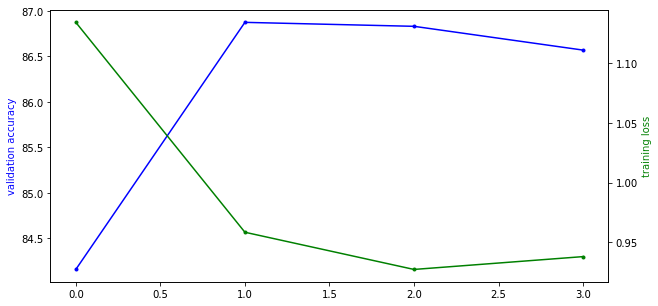

  accuracy        F1             loss        time [ms]  name
test  train   test  train   test     train
80.38 97.45   80.39 97.45   1.27e+00 5.88e-01    43   cgconv_cgconv_fc_softmax
85.64 99.66   85.67 99.66   8.44e-01 3.42e-01     6   fgconv_fgconv_fc_softmax
84.91 95.45   84.94 95.45   7.58e-01 4.58e-01     6   sgconv_sgconv_fc_softmax


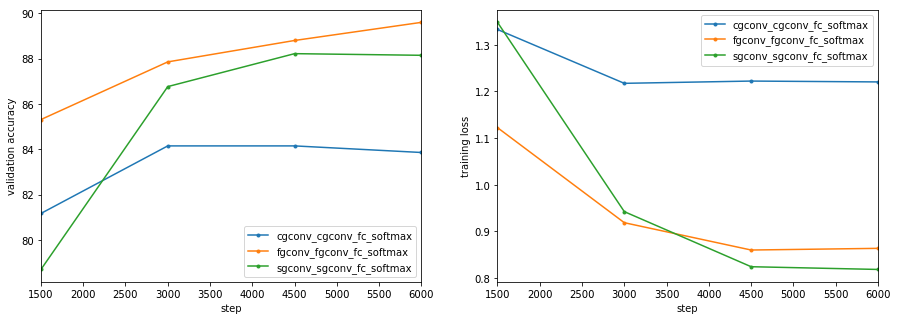

In [17]:
# Common hyper-parameters for LeNet5-like networks (two convolutional layers).
common['regularization'] = 5e-4
common['dropout']        = 0.5
common['learning_rate']  = 0.02  # 0.03 in the paper but sgconv_sgconv_fc_softmax has difficulty to converge
common['decay_rate']     = 0.95
common['momentum']       = 0.9
common['F']              = [32, 64, 128]  # Number of graph convolutional filters.
common['K']              = [25, 25, 25]  # Polynomial orders.
common['p']              = [4, 4, 4]    # Pooling sizes.
common['M']              = [256, C]  # Output dimensionality of fully connected layers.

##model#1: two convolutional layers with fourier transform as filters
name = 'fgconv_fgconv_fc_softmax' #  'Non-Param'
params = common.copy()
params['dir_name'] += name
params['filter'] = 'fourier'
params['K'] = np.zeros(len(common['p']), dtype=int)
for pi,li in zip(common['p'],range(len(common['p']))):
    if pi == 2: 
        params['K'][li] = L[li].shape[0]
    if pi == 4:
        params['K'][li] = L[li*2].shape[0]
print(params['K'])    
#params['K'] = [L[0].shape[0], L[2].shape[0]]
print([L[li].shape for li in range(len(L))])
model = models.cgcnn(L, **params)
    
d = {k: v+1 for v, k in enumerate(sorted(set(Y_test)))}
test_labels = np.array([d[x] for x in Y_test])
print(np.unique(Y_test))

train_acc = []; train_loss = [];
test_acc = []; test_loss = [];
val_acc = []; val_loss = [];
accuracy = []; loss = []; t_step = [];
for x_train, y_train, x_val, y_val,tcount in zip(X_train, Y_train, X_val, Y_val,range(5)):
    
    train_data = coarsening.perm_data(x_train.reshape(-1,Region_Num), perm)
    train_labels = np.array([d[x] for x in y_train])
    val_data = coarsening.perm_data(x_val.reshape(-1,Region_Num), perm)
    val_labels = np.array([d[x] for x in y_val])
    test_data = coarsening.perm_data(X_test.reshape(-1,Region_Num), perm)
    print('\nFold #%d: training on %d samples with %d features, validating on %d samples and testing on %d samples' % 
          (tcount+1,train_data.shape[0],train_data.shape[1],val_data.shape[0],test_data.shape[0]))  
    
    ###training
    model = models.cgcnn(L, **params)
    acc, los, tstep = model.fit(train_data, train_labels, val_data, val_labels)
    accuracy.append(acc)
    loss.append(los)
    t_step.append(tstep)

    ##evaluation
    model_perf.test(model, name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)
    train_acc.append(model_perf.train_accuracy[name])
    train_loss.append(model_perf.train_loss[name])
    test_acc.append(model_perf.test_accuracy[name])
    test_loss.append(model_perf.test_loss[name])
    val_acc.append(model_perf.fit_accuracies[name])
    val_loss.append(model_perf.fit_losses[name])
    print('\n')
       
print('Accuracy of training:{},testing:{}'.format(np.mean(train_acc),np.mean(test_acc)))
print('Accuracy of validation:',np.max(val_acc,axis=1))
print(' mean=%2f' % np.mean(np.max(val_acc,axis=1)))

###training figures
print(accuracy, loss,t_step )
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(np.mean(accuracy,axis=0), 'b.-')
ax1.set_ylabel('validation accuracy', color='b')
ax2 = ax1.twinx()
ax2.plot(np.mean(loss,axis=0), 'g.-')
ax2.set_ylabel('training loss', color='g')
plt.show()

###summarize the results
model_perf.show()

{'dir_name': 'WMsgconv_sgconv_fc_softmax', 'num_epochs': 50, 'batch_size': 128, 'decay_steps': 3768.375, 'eval_frequency': 1500, 'brelu': 'b1relu', 'pool': 'mpool1', 'regularization': 0.0005, 'dropout': 0.5, 'learning_rate': 0.02, 'decay_rate': 0.95, 'momentum': 0.9, 'F': [32, 64, 128], 'K': [25, 25, 25], 'p': [4, 4, 4], 'M': [256, 9], 'filter': 'spline'}
[(576, 576), (288, 288), (144, 144), (72, 72), (36, 36), (18, 18), (9, 9)]
NN architecture
  input: M_0 = 576
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 576 * 32 / 4 = 4608
    weights: F_0 * F_1 * K_1 = 1 * 32 * 25 = 800
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 144 * 64 / 4 = 2304
    weights: F_1 * F_2 * K_2 = 32 * 64 * 25 = 51200
    biases: F_2 = 64
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 36 * 128 / 4 = 1152
    weights: F_2 * F_3 * K_3 = 64 * 128 * 25 = 204800
    biases: F_3 = 128
  layer 4: fc1
    representation: M_4 = 256
    weights: M_3 * M_4 = 1152 * 256 =

step 3000 / 4831 (epoch 31.05 / 50):
  learning_rate = 2.00e-02, loss_average = 7.59e-01
  validation accuracy: 81.03 (1115 / 1376), f1 (weighted): 81.14, loss: 1.14e+00
  time: 15s (wall 17s)
step 4500 / 4831 (epoch 46.57 / 50):
  learning_rate = 1.90e-02, loss_average = 5.33e-01
  validation accuracy: 85.39 (1175 / 1376), f1 (weighted): 85.41, loss: 9.68e-01
  time: 21s (wall 25s)
step 4831 / 4831 (epoch 50.00 / 50):
  learning_rate = 1.90e-02, loss_average = 4.98e-01
  validation accuracy: 84.67 (1165 / 1376), f1 (weighted): 84.68, loss: 9.48e-01
  time: 24s (wall 28s)
validation accuracy: peak = 85.39, mean = 81.20
step 1500 / 4831 (epoch 15.52 / 50):
  learning_rate = 2.00e-02, loss_average = 1.11e+00
  validation accuracy: 76.45 (1052 / 1376), f1 (weighted): 76.40, loss: 1.41e+00
  time: 8s (wall 9s)
step 3000 / 4831 (epoch 31.05 / 50):
  learning_rate = 2.00e-02, loss_average = 7.11e-01
  validation accuracy: 82.27 (1132 / 1376), f1 (weighted): 82.25, loss: 1.10e+00
  time: 14s 

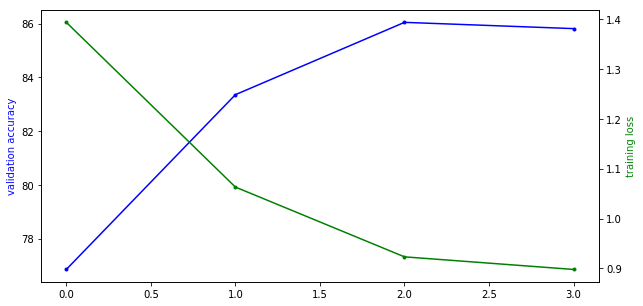

  accuracy        F1             loss        time [ms]  name
test  train   test  train   test     train
59.10 88.14   59.13 88.14   1.56e+00 4.48e-01     6   fgconv_fgconv_fc_softmax
84.91 95.45   84.94 95.45   7.58e-01 4.58e-01     6   sgconv_sgconv_fc_softmax


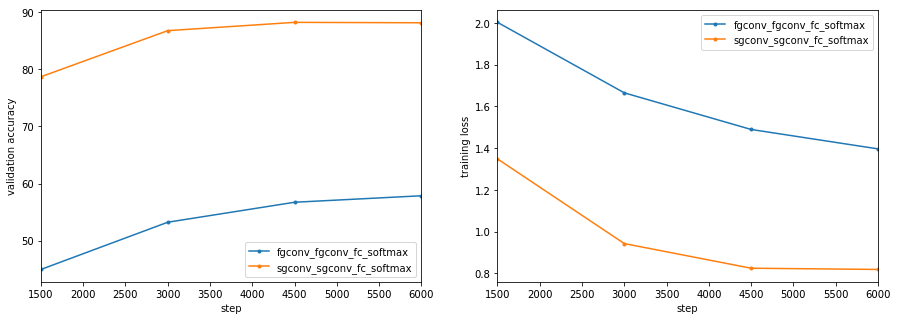

In [14]:
# Common hyper-parameters for LeNet5-like networks (two convolutional layers).
common['regularization'] = 5e-4
common['dropout']        = 0.5
common['learning_rate']  = 0.02  # 0.03 in the paper but sgconv_sgconv_fc_softmax has difficulty to converge
common['decay_rate']     = 0.95
common['momentum']       = 0.9
common['F']              = [32, 64, 128]  # Number of graph convolutional filters.
common['K']              = [25, 25, 25]  # Polynomial orders.
common['p']              = [4, 4, 4]    # Pooling sizes.
common['M']              = [256, C]  # Output dimensionality of fully connected layers.

##model#2: two convolutional layers with spline basis as filters
name = 'sgconv_sgconv_fc_softmax' #  'Non-Param'
params = common.copy()
params['dir_name'] += name
params['filter'] = 'spline'
print(params)    
print([L[li].shape for li in range(len(L))])
model = models.cgcnn(L, **params)
    
d = {k: v+1 for v, k in enumerate(sorted(set(Y_test)))}
test_labels = np.array([d[x] for x in Y_test])
print(np.unique(Y_test))

train_acc = []; train_loss = [];
test_acc = []; test_loss = [];
val_acc = []; val_loss = [];
accuracy = []; loss = []; t_step = [];
for x_train, y_train, x_val, y_val,tcount in zip(X_train, Y_train, X_val, Y_val,range(5)):
    
    train_data = coarsening.perm_data(x_train.reshape(-1,Region_Num), perm)
    train_labels = np.array([d[x] for x in y_train])
    val_data = coarsening.perm_data(x_val.reshape(-1,Region_Num), perm)
    val_labels = np.array([d[x] for x in y_val])
    test_data = coarsening.perm_data(X_test.reshape(-1,Region_Num), perm)
    print('\nFold #%d: training on %d samples with %d features, validating on %d samples and testing on %d samples' % 
          (tcount+1,train_data.shape[0],train_data.shape[1],val_data.shape[0],test_data.shape[0]))  
    
    ###training
    model = models.cgcnn(L, **params)
    acc, los, tstep = model.fit(train_data, train_labels, val_data, val_labels)
    accuracy.append(acc)
    loss.append(los)
    t_step.append(tstep)

    ##evaluation
    model_perf.test(model, name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)
    train_acc.append(model_perf.train_accuracy[name])
    train_loss.append(model_perf.train_loss[name])
    test_acc.append(model_perf.test_accuracy[name])
    test_loss.append(model_perf.test_loss[name])
    val_acc.append(model_perf.fit_accuracies[name])
    val_loss.append(model_perf.fit_losses[name])
    print('\n')
       
print('Accuracy of training:{},testing:{}'.format(np.mean(train_acc),np.mean(test_acc)))
print('Accuracy of validation:',np.max(val_acc,axis=1))
print(' mean=%2f' % np.mean(np.max(val_acc,axis=1)))

###training figures
print(accuracy, loss,t_step )
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(np.mean(accuracy,axis=0), 'b.-')
ax1.set_ylabel('validation accuracy', color='b')
ax2 = ax1.twinx()
ax2.plot(np.mean(loss,axis=0), 'g.-')
ax2.set_ylabel('training loss', color='g')
plt.show()

###summarize the results
model_perf.show()

{'dir_name': 'WMcgconv_cgconv_fc_softmax', 'num_epochs': 50, 'batch_size': 128, 'decay_steps': 3768.375, 'eval_frequency': 1500, 'brelu': 'b1relu', 'pool': 'mpool1', 'regularization': 0.0005, 'dropout': 0.5, 'learning_rate': 0.005, 'decay_rate': 0.9, 'momentum': 0.9, 'F': [32, 64, 128], 'K': [25, 25, 25], 'p': [4, 4, 4], 'M': [256, 9], 'filter': 'chebyshev5'}
[(576, 576), (288, 288), (144, 144), (72, 72), (36, 36), (18, 18), (9, 9)]
NN architecture
  input: M_0 = 576
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 576 * 32 / 4 = 4608
    weights: F_0 * F_1 * K_1 = 1 * 32 * 25 = 800
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 144 * 64 / 4 = 2304
    weights: F_1 * F_2 * K_2 = 32 * 64 * 25 = 51200
    biases: F_2 = 64
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 36 * 128 / 4 = 1152
    weights: F_2 * F_3 * K_3 = 64 * 128 * 25 = 204800
    biases: F_3 = 128
  layer 4: fc1
    representation: M_4 = 256
    weights: M_3 * M_4 = 1152 * 2

  validation accuracy: 79.07 (1088 / 1376), f1 (weighted): 79.14, loss: 1.51e+00
  time: 35s (wall 66s)
step 3000 / 4831 (epoch 31.05 / 50):
  learning_rate = 5.00e-03, loss_average = 7.51e-01
  validation accuracy: 81.83 (1126 / 1376), f1 (weighted): 81.79, loss: 1.47e+00
  time: 66s (wall 129s)
step 4500 / 4831 (epoch 46.57 / 50):
  learning_rate = 4.50e-03, loss_average = 6.04e-01
  validation accuracy: 81.90 (1127 / 1376), f1 (weighted): 81.89, loss: 1.62e+00
  time: 96s (wall 190s)
step 4831 / 4831 (epoch 50.00 / 50):
  learning_rate = 4.50e-03, loss_average = 5.93e-01
  validation accuracy: 81.54 (1122 / 1376), f1 (weighted): 81.53, loss: 1.64e+00
  time: 105s (wall 206s)
validation accuracy: peak = 81.90, mean = 81.09
step 1500 / 4831 (epoch 15.52 / 50):
  learning_rate = 5.00e-03, loss_average = 1.11e+00
  validation accuracy: 78.20 (1076 / 1376), f1 (weighted): 78.07, loss: 1.63e+00
  time: 34s (wall 66s)
step 3000 / 4831 (epoch 31.05 / 50):
  learning_rate = 5.00e-03, loss_av

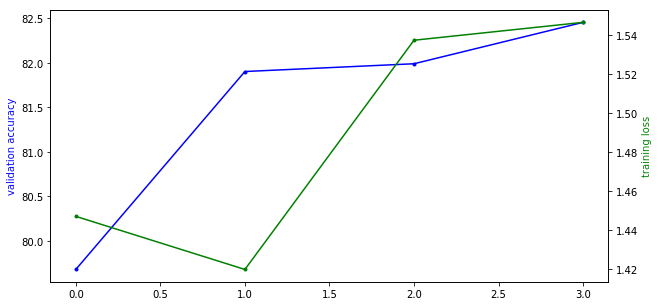

  accuracy        F1             loss        time [ms]  name
test  train   test  train   test     train
80.38 97.45   80.39 97.45   1.27e+00 5.88e-01    43   cgconv_cgconv_fc_softmax
59.10 88.14   59.13 88.14   1.56e+00 4.48e-01     6   fgconv_fgconv_fc_softmax
84.91 95.45   84.94 95.45   7.58e-01 4.58e-01     6   sgconv_sgconv_fc_softmax


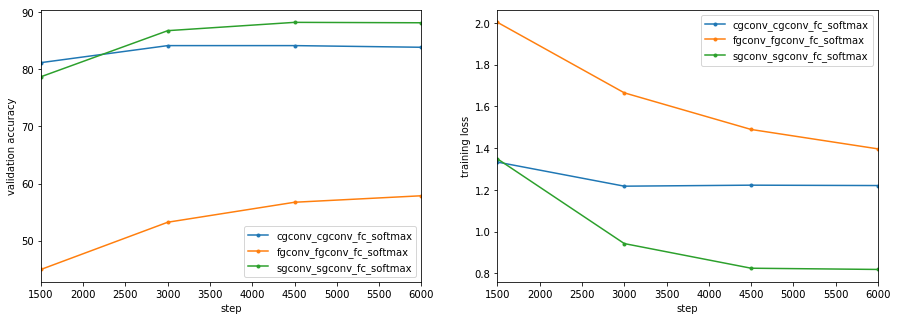

In [15]:
# Common hyper-parameters for LeNet5-like networks (two convolutional layers).
common['regularization'] = 5e-4
common['dropout']        = 0.5
common['learning_rate']  = 0.005  # 0.03 in the paper but sgconv_sgconv_fc_softmax has difficulty to converge
common['decay_rate']     = 0.9 ##0.95
common['momentum']       = 0.9
common['F']              = [32, 64, 128]  # Number of graph convolutional filters.
common['K']              = [ 25,25,25]  # Polynomial orders.
common['p']              = [4,4,4]    # Pooling sizes.
common['M']              = [256, C]  # Output dimensionality of fully connected layers.

##model#3: two convolutional layers with Chebyshev polynomial as filters
name = 'cgconv_cgconv_fc_softmax' #  'Non-Param'
params = common.copy()
params['dir_name'] += name
params['filter'] = 'chebyshev5'
print(params)    
print([L[li].shape for li in range(len(L))])
model = models.cgcnn(L, **params)
    
d = {k: v+1 for v, k in enumerate(sorted(set(Y_test)))}
test_labels = np.array([d[x] for x in Y_test])
print(np.unique(Y_test))

train_acc = []; train_loss = [];
test_acc = []; test_loss = [];
val_acc = []; val_loss = [];
accuracy = []; loss = []; t_step = [];
for x_train, y_train, x_val, y_val,tcount in zip(X_train, Y_train, X_val, Y_val,range(5)):
    
    train_data = coarsening.perm_data(x_train.reshape(-1,Region_Num), perm)
    train_labels = np.array([d[x] for x in y_train])
    val_data = coarsening.perm_data(x_val.reshape(-1,Region_Num), perm)
    val_labels = np.array([d[x] for x in y_val])
    test_data = coarsening.perm_data(X_test.reshape(-1,Region_Num), perm)
    print('\nFold #%d: training on %d samples with %d features, validating on %d samples and testing on %d samples' % 
          (tcount+1,train_data.shape[0],train_data.shape[1],val_data.shape[0],test_data.shape[0]))  
    
    ###training
    acc, los, tstep = model.fit(train_data, train_labels, val_data, val_labels)
    accuracy.append(acc)
    loss.append(los)
    t_step.append(tstep)

    ##evaluation
    model_perf.test(model, name, params,
                    train_data, train_labels, val_data, val_labels, test_data, test_labels)
    train_acc.append(model_perf.train_accuracy[name])
    train_loss.append(model_perf.train_loss[name])
    test_acc.append(model_perf.test_accuracy[name])
    test_loss.append(model_perf.test_loss[name])
    val_acc.append(model_perf.fit_accuracies[name])
    val_loss.append(model_perf.fit_losses[name])
    print('\n')
       
print('Accuracy of training:{},testing:{}'.format(np.mean(train_acc),np.mean(test_acc)))
print('Accuracy of validation:',np.max(val_acc,axis=1))
print(' mean=%2f' % np.mean(np.max(val_acc,axis=1)))

###training figures
print(accuracy, loss,t_step )
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(np.mean(accuracy,axis=0), 'b.-')
ax1.set_ylabel('validation accuracy', color='b')
ax2 = ax1.twinx()
ax2.plot(np.mean(loss,axis=0), 'g.-')
ax2.set_ylabel('training loss', color='g')
plt.show()

###summarize the results
model_perf.show()